<a href="https://colab.research.google.com/github/ZinoTAT/Machine-Learning/blob/master/pytorch/practices/%E9%9A%90%E5%B1%82%E5%8F%AF%E6%94%B9%E5%8F%98%E6%A8%A1%E5%9E%8B_MNIST%E6%89%8B%E5%86%99%E6%95%B0%E6%8D%AE%E9%9B%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

本来是是想看一看模型复杂程度与欠拟合、过拟合之间的关系，因此搭建了一个中间隐藏层数可以自定义，激活函数为reLU函数的全连接网络，然而在实验中发现随着隐藏层数的增加(0,1,2,3),从欠拟合到过拟合的表现并未出现。

In [1]:
import torch 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
print(torch.__version__)

1.4.0


In [0]:
batch_size = 200
learning_rate=0.01
epochs = 20
hidden_size = 5

In [3]:
train_db = datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
    ]))
train_loader = torch.utils.data.DataLoader(
    train_db,
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=batch_size, shuffle=True
)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!





定义一个输入为784，输出为10的网络中间隐藏层数自定义

In [0]:
class MLP(nn.Module):
  def __init__(self, hidden_size=1):
    super(MLP,self).__init__()
    self.hidden_layers = nn.ModuleList([])

    self.input_layer = nn.Sequential(
        nn.Linear(784, 200),
        nn.ReLU(inplace=True),
    )
    self.output_layer = nn.Sequential(
        nn.Linear(200, 10),
        nn.ReLU(inplace=True),
    )
    for i in range(hidden_size):
      hidden_layer = nn.Sequential(
            nn.Linear(200, 200),
            nn.ReLU(inplace=True),
          )
      self.hidden_layers.append(hidden_layer)
    
  def forward(self, x):
    x =self.input_layer(x)
    for layer in self.hidden_layers:
      x = layer(x)
    x = self.output_layer(x)
    return x

In [0]:
def train(net, train_loader, device, criteon, optimizer, epochs=20):
  for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
      data = data.reshape(-1, 28 * 28)
      data, target = data.to(device), target.to(device)
      logits = net.forward(data)
      loss = criteon(logits, target)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  return loss

    

In [0]:
def test(net, test_loader, device, criteon, optimizer):
  correct = 0
  for data, target in test_loader:
    data = data.view(-1, 28 * 28)
    data, target = data.to(device), target.to(device)
    logits = net.forward(data)
    pred = logits.data.max(1)[1]
    correct += pred.eq(target.data).sum()
  return float(correct) / float(len(test_loader) * test_loader.batch_size)

In [7]:
device = torch.device('cuda')
print(device)

cuda


In [0]:
def instance(hidden_size, train_loader, test_loader, device, learning_rate, epochs):
  net = MLP(hidden_size).to(device)
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)
  criteon = nn.CrossEntropyLoss().to(device)
  loss = train(net, train_loader, device, criteon, optimizer, epochs)
  correct = test(net, test_loader, device, criteon, optimizer)
  return loss, correct

In [10]:
losses = []
corrects = []
for i in range(hidden_size):
  inst = instance(i, train_loader, test_loader, device, learning_rate, epochs)
  print("隐藏层数:{}\tloss:{}\t测试准确率".format(i, inst[0].item(), inst[1]))
  losses.append(inst[0])
  corrects.append(inst[1])

隐藏层数:0	loss:0.9250686764717102	测试准确率
隐藏层数:1	loss:0.11836864799261093	测试准确率
隐藏层数:2	loss:0.9032832384109497	测试准确率
隐藏层数:3	loss:0.40546780824661255	测试准确率
隐藏层数:4	loss:0.8762038350105286	测试准确率


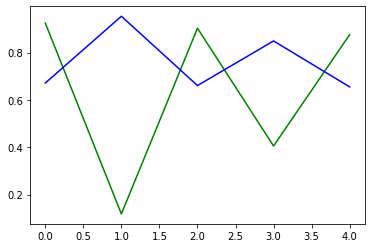

In [11]:
x = np.linspace(0, hidden_size - 1, hidden_size)
fig = plt.figure('f')
plt.plot(x, losses, c='g')
plt.plot(x, corrects, c='b')
plt.show()

横坐标为隐藏层数量，绿线为训练的loss，蓝线为在测试集上的准确率